In [44]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [45]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [46]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


In [47]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


In [48]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


In [49]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


In [50]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults


In [51]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


In [52]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


In [53]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


In [54]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


In [55]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


In [56]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


In [111]:
def geneticAlgorithm(cityList, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, cityList)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        if i%100 == 0:
            print(f"Generation nr.: {i}")
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


In [69]:
cityList = []

for i in range(0, 25):
    cityList.append(City(x=int(random.random() * 200),
                         y=int(random.random() * 200)))
cityList

[(41,39),
 (122,167),
 (171,90),
 (32,194),
 (49,181),
 (165,123),
 (4,146),
 (171,131),
 (147,21),
 (183,9),
 (163,46),
 (162,105),
 (55,17),
 (103,114),
 (186,32),
 (90,193),
 (43,157),
 (168,69),
 (130,21),
 (71,176),
 (65,180),
 (38,97),
 (97,191),
 (196,183),
 (115,169)]

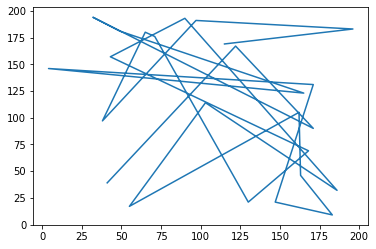

In [105]:
x, y = [], []
for item in cityList:
    x.append(item.x)
    y.append(item.y)
plt.plot(x,y)

In [112]:
bestRoute = geneticAlgorithm(cityList=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=1000)
bestRoute

Initial distance: 2182.1486679762243
Generation nr.: 0
Generation nr.: 100
Generation nr.: 200
Generation nr.: 300
Generation nr.: 400
Generation nr.: 500
Generation nr.: 600
Generation nr.: 700
Generation nr.: 800
Generation nr.: 900
Final distance: 836.5088858984926


[(55,17),
 (41,39),
 (38,97),
 (4,146),
 (43,157),
 (32,194),
 (49,181),
 (65,180),
 (71,176),
 (90,193),
 (97,191),
 (115,169),
 (122,167),
 (103,114),
 (196,183),
 (171,131),
 (165,123),
 (162,105),
 (171,90),
 (168,69),
 (163,46),
 (186,32),
 (183,9),
 (147,21),
 (130,21)]

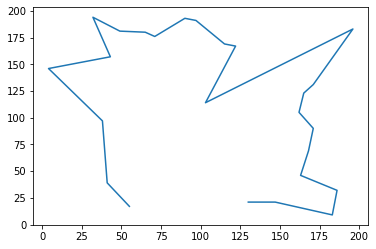

In [113]:
x,y = [],[]
for item in bestRoute:
    x.append(item.x)
    y.append(item.y)
plt.plot(x,y)

In [60]:
def geneticAlgorithmPlot(cityList, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, cityList)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

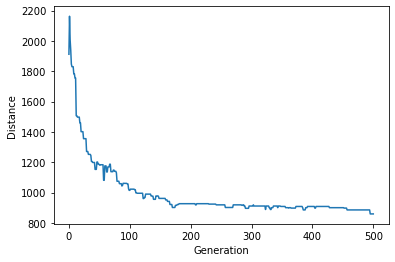

In [61]:
geneticAlgorithmPlot(cityList=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
